In [1]:
# ============================================================
# ✅ Non-Uniform Illumination Robustness Experiment
# Dataset : TinyImageNet (subset, auto-downloaded)
# Model   : Small CNN
# Goal    : Show large accuracy drop (20–30%) with strong NUI
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os, urllib.request, zipfile

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


In [3]:

# ------------------------------------------------------------
# 🧩 Auto-download TinyImageNet (if not present)
# ------------------------------------------------------------
data_root = "./TinyImageNet"
zip_path = os.path.join(data_root, "tiny-imagenet-200.zip")
extract_path = os.path.join(data_root, "tiny-imagenet-200")

if not os.path.exists(extract_path):
    os.makedirs(data_root, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    print("📦 Downloading TinyImageNet (~250MB)...")
    urllib.request.urlretrieve(url, zip_path)
    print("✅ Download complete. Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("✅ Extraction complete.")
else:
    print("✅ TinyImageNet already available.")

# ------------------------------------------------------------
# 1️⃣ Define Strong Non-Uniform Illumination Mask
# ------------------------------------------------------------
def generate_directional_mask(h, w, strength=3.0, exponent=2.0):
    """Generate strong directional illumination mask (bright→dark gradient)."""
    yy, xx = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w), indexing='ij')
    angle = np.random.uniform(0, np.pi)
    grad = np.cos(angle) * xx + np.sin(angle) * yy
    grad = (grad - grad.min()) / (grad.max() - grad.min())
    mask = grad ** exponent
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0, 2).astype(np.float32)
    return mask

def apply_mask_to_tensor(img_tensor, mask):
    mask = torch.tensor(mask).unsqueeze(0)
    if img_tensor.shape[1:] != mask.shape[1:]:
        mask = torch.nn.functional.interpolate(
            mask.unsqueeze(0), size=img_tensor.shape[1:], mode='bilinear', align_corners=False
        ).squeeze(0)
    return img_tensor * mask

# ------------------------------------------------------------
# 2️⃣ Load TinyImageNet Subset (only 5 classes for speed)
# ------------------------------------------------------------
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

dataset_path = os.path.join(extract_path, "train")
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
print("Total TinyImageNet train samples:", len(full_dataset))

# Pick 5 random classes
class_indices = random.sample(range(200), 5)
print("Selected classes:", class_indices)

# Filter only those samples
subset_samples = [(path, label) for path, label in full_dataset.samples if label in class_indices]

# ✅ Remap labels to 0–4
label_map = {old: new for new, old in enumerate(class_indices)}
subset_samples = [(path, label_map[label]) for path, label in subset_samples]

# Replace dataset samples
full_dataset.samples = subset_samples
full_dataset.targets = [label for _, label in subset_samples]

# Subset for quick testing
subset_idx = list(range(min(2000, len(full_dataset))))
dataset = Subset(full_dataset, subset_idx)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(class_indices)
print(f"Training samples: {len(trainset)} | Test samples: {len(testset)} | Classes: {num_classes}")

# ------------------------------------------------------------
# 3️⃣ Define CNN
# ------------------------------------------------------------
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ------------------------------------------------------------
# 4️⃣ Training Function
# ------------------------------------------------------------
def train_model(model, loader, optimizer, criterion, epochs=3, apply_nui=False):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            if apply_nui:
                imgs_aug = []
                for img in imgs:
                    if np.random.rand() < 0.7:
                        mask = generate_directional_mask(
                            64, 64,
                            strength=np.random.uniform(-3.0, 3.0),
                            exponent=np.random.uniform(0.8, 3.5)
                        )
                        img = apply_mask_to_tensor(img, mask)
                    imgs_aug.append(img)
                imgs = torch.stack(imgs_aug)
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Loss: {total_loss / len(loader):.4f}")

# ------------------------------------------------------------
# 5️⃣ Evaluation Function
# ------------------------------------------------------------
def evaluate(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            if apply_nui:
                imgs_aug = []
                for img in imgs:
                    mask = generate_directional_mask(64, 64, strength=3.0, exponent=2.0)
                    img = apply_mask_to_tensor(img, mask)
                    imgs_aug.append(img)
                imgs = torch.stack(imgs_aug)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total

# ------------------------------------------------------------
# 6️⃣ Baseline Training (Clean)
# ------------------------------------------------------------
model_clean = TinyCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)

print("\n=== Training Baseline Model (Clean) ===")
train_model(model_clean, trainloader, optimizer, criterion, epochs=3, apply_nui=False)

acc_clean = evaluate(model_clean, testloader, apply_nui=False)
acc_nui = evaluate(model_clean, testloader, apply_nui=True)

print("\nBefore Robust Training:")
print(f"Clean test accuracy: {acc_clean*100:.2f}%")
print(f"NUI test accuracy:   {acc_nui*100:.2f}%")
print("-" * 40)

# ------------------------------------------------------------
# 7️⃣ NUI-Augmented Training
# ------------------------------------------------------------
model_nui = TinyCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nui.parameters(), lr=0.001)

print("\n=== Training Robust Model (NUI-Augmented) ===")
train_model(model_nui, trainloader, optimizer, criterion, epochs=3, apply_nui=True)

acc_clean_aug = evaluate(model_nui, testloader, apply_nui=False)
acc_nui_aug = evaluate(model_nui, testloader, apply_nui=True)

print("\nAfter NUI-Augmented Training:")
print(f"Clean test accuracy: {acc_clean_aug*100:.2f}%")
print(f"NUI test accuracy:   {acc_nui_aug*100:.2f}%")
print("-" * 40)

print(f"Accuracy Drop Before: {abs(acc_clean - acc_nui)*100:.2f}%")
print(f"Accuracy Drop After:  {abs(acc_clean_aug - acc_nui_aug)*100:.2f}%")

✅ TinyImageNet already available.
Total TinyImageNet train samples: 100000
Selected classes: [40, 42, 103, 129, 192]
Training samples: 1600 | Test samples: 400 | Classes: 5

=== Training Baseline Model (Clean) ===


Epoch 1/3: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Loss: 1.5024


Epoch 2/3: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Loss: 0.8711


Epoch 3/3: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Loss: 0.7799

Before Robust Training:
Clean test accuracy: 60.25%
NUI test accuracy:   43.25%
----------------------------------------

=== Training Robust Model (NUI-Augmented) ===


Epoch 1/3: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Loss: 1.6401


Epoch 2/3: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Loss: 1.0186


Epoch 3/3: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Loss: 0.8798

After NUI-Augmented Training:
Clean test accuracy: 61.00%
NUI test accuracy:   55.00%
----------------------------------------
Accuracy Drop Before: 17.00%
Accuracy Drop After:  6.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


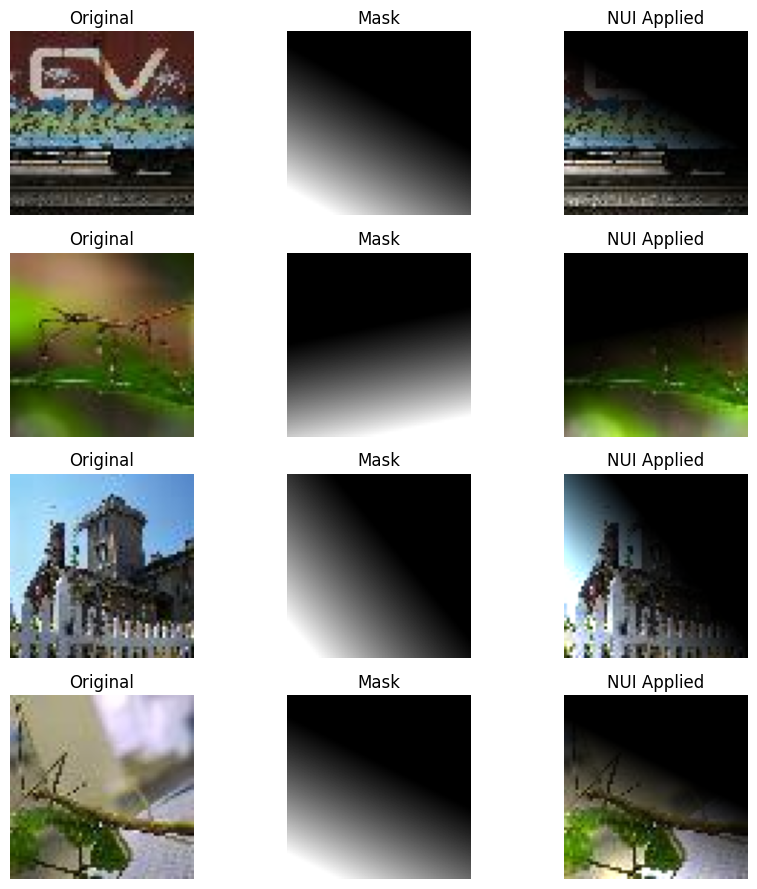

In [4]:
# ------------------------------------------------------------
# 📊 6️⃣ Visualization Function
# ------------------------------------------------------------
def visualize_nui_effect(num_images=4):
    imgs, _ = next(iter(testloader))
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    for i in range(num_images):
        img = imgs[i]
        mask = generate_directional_mask(64, 64, strength=3.0, exponent=2.0)
        img_nui = apply_mask_to_tensor(img, mask)
        axes[i,0].imshow(img.permute(1,2,0)); axes[i,0].set_title("Original"); axes[i,0].axis("off")
        axes[i,1].imshow(mask, cmap="gray"); axes[i,1].set_title("Mask"); axes[i,1].axis("off")
        axes[i,2].imshow(img_nui.permute(1,2,0)); axes[i,2].set_title("NUI Applied"); axes[i,2].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize few samples
visualize_nui_effect()